1. Import required libraries for data preparation

In [1]:
import gc
import os, types
from botocore.client import Config
import ibm_boto3
import warnings
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Sklearn imports
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix, roc_curve 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)


                       

2. Import datasets

In [2]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {
    'data_name': """Model Data Initial.csv""",
    'interaction_properties': {
        #'row_limit': 500,
        'infer_schema': 'true',
        'infer_as_varchar': 'false'
    }
}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

df = itcfs.read_pandas_and_concat(readClient, flightInfo, timeout=240)
df.head(10)



,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
0,10,Female,n/a,n/a,n/a,Housewife,n/a,61.097878,1,F
1,20,Female,n/a,n/a,n/a,n/a,n/a,57.982204,1,F
2,30,Female,n/a,Greek Cypriot,n/a,Housewife,n/a,45.859001,1,F
3,40,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,NaN,1,F
4,50,Female,n/a,Greek Cypriot,n/a,Private Company / Partnership,Other Professionals,55.956194,1,F
5,60,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,44.164271,1,F
6,70,Male,Married,Greek Cypriot,n/a,Government - Semi-Government,Skilled Worker,54.203970,2,F
7,110,Female,Married,British,n/a,Retired,n/a,53.571526,4,F
8,156,Male,n/a,Other,n/a,Retired,n/a,88.292950,3,F
9,173,Female,Married,British,n/a,Private Company / Partnership,Salesmen,44.539357,5,F


In [3]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {
    'data_name': """Demographics_shap.csv""",
    'interaction_properties': {
        #'row_limit': 500,
        'infer_schema': 'true',
        'infer_as_varchar': 'false'
    }
}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

dates = itcfs.read_pandas_and_concat(readClient, flightInfo, timeout=240)

dates= dates [['CUST_ID', 'DATE_OF_BIRTH' ,'FIRST_CUSTOMER_OPENING_DATE']]
dates['DATE_OF_BIRTH'] = pd.to_datetime(dates.DATE_OF_BIRTH )
dates['FIRST_CUSTOMER_OPENING_DATE'] = pd.to_datetime(dates.FIRST_CUSTOMER_OPENING_DATE)
dates.head(3)


,CUST_ID,DATE_OF_BIRTH,FIRST_CUSTOMER_OPENING_DATE
0,10,1943-03-26,1995-07-08
1,20,1946-05-07,1995-07-08
2,30,1958-06-21,1995-07-08


3. Drop 1 table Column
4. Rename List of table Columns
5. Create List of table Columns based on condition
6. For loops
7. fillna, isna, head functions

In [4]:
df_2 = df.copy()
df= df.drop(['CUST_ID'], axis=1)

df = df.rename(columns={'NATIONALITY': 'NATIONALITY_new', 'OCCUPATION': 'OCCUPATION_New'})
df.head()

cols = [c for c in df.columns]
cat_cols = [c for c in df.columns if df[c].dtype == 'object' ]
num_cols = [c for c in df.columns if df[c].dtype!='object']

for col in cols:
    print (col , df[col].isna().sum())
    
for col in cat_cols:
    df[col].fillna("No info", inplace = True)
 
    for col in num_cols:
        df[col] = df[col].fillna (df[col].median())
        
    
df.head()


GENDER 0
MARITAL_STATUS 0
NATIONALITY_new 0
EDUCATION 0
EMPLOYMENT 0
OCCUPATION_New 0
AGE_IN_YEARS 8
NO_OF_DIFFERENT_PRODUCTS 0
LOAN_DEFAULT 0


,GENDER,MARITAL_STATUS,NATIONALITY_new,EDUCATION,EMPLOYMENT,OCCUPATION_New,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
0,Female,n/a,n/a,n/a,Housewife,n/a,61.097878,1,F
1,Female,n/a,n/a,n/a,n/a,n/a,57.982204,1,F
2,Female,n/a,Greek Cypriot,n/a,Housewife,n/a,45.859001,1,F
3,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,36.260096,1,F
4,Female,n/a,Greek Cypriot,n/a,Private Company / Partnership,Other Professionals,55.956194,1,F


8. pd.factorize function to Convert text - boolean Variables to Dummy
9. pd.get_dummies function to Convert text - LOV Variables to Dummy

In [5]:

df_categorical = df[cat_cols].copy()
for col in cat_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

df_categorical.head(3)

,LOAN_DEFAULT,GENDER_Female,GENDER_Male,GENDER_n/a,MARITAL_STATUS_Divorced,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Widowed,MARITAL_STATUS_n/a,NATIONALITY_new_British,...,OCCUPATION_New_Salesmen,OCCUPATION_New_Skilled Worker,OCCUPATION_New_Solicitors,OCCUPATION_New_Students,OCCUPATION_New_Teachers / Professors,OCCUPATION_New_Technicians,OCCUPATION_New_Travel Agents/Airline Employees,OCCUPATION_New_University / College,OCCUPATION_New_Unskilled Worker,OCCUPATION_New_n/a
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


10. Create 1 function that creates distribution plot (sns.distplot) and Normalizes the numerical Variables

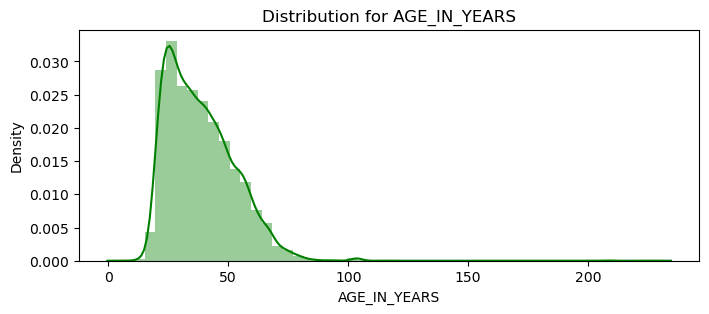

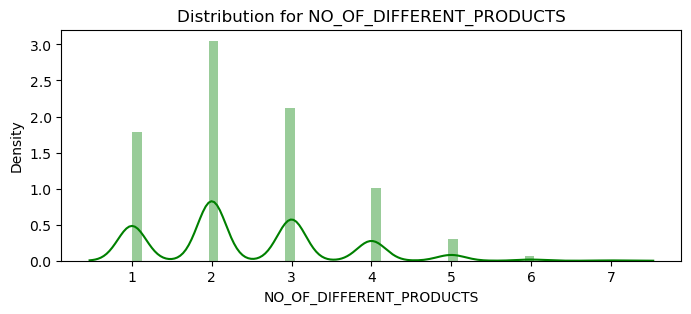

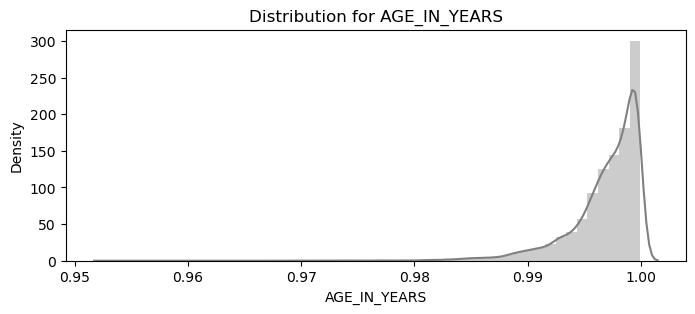

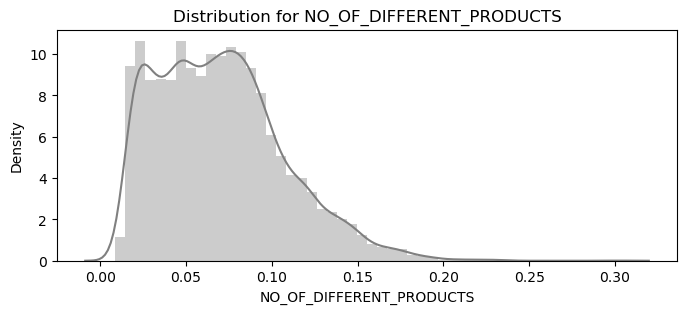

In [6]:
def distplot(feature, frame, color='g'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

df[num_cols].describe()
for feat in num_cols: distplot(feat, df)
df_std = pd.DataFrame( Normalizer().fit(df[num_cols]).transform(df[num_cols]),
                       columns=num_cols)
for feat in num_cols: distplot(feat, df_std, color='gray')
 


11. Create BarPlot (matplotlib.pyplot) 

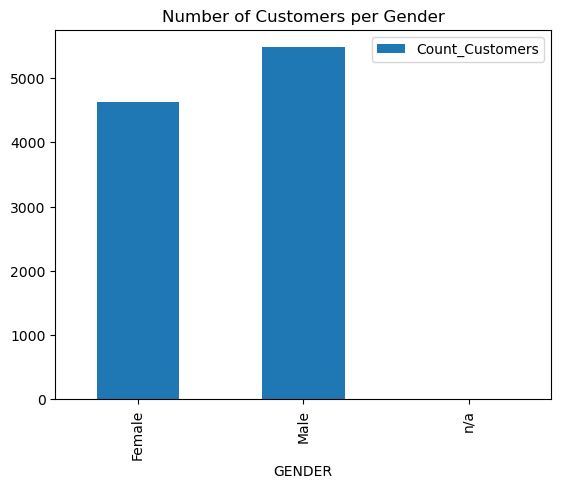

In [7]:
task2= df_2.groupby(["GENDER"])["CUST_ID"].count().reset_index(name="Count_Customers")

ax = task2.plot.bar(x='GENDER', y='Count_Customers', title = 'Number of Customers per Gender')

12. Line Chart (matplotlib.pyplot) 

In [8]:
dates['weekday'] = dates['DATE_OF_BIRTH'].dt.dayofweek

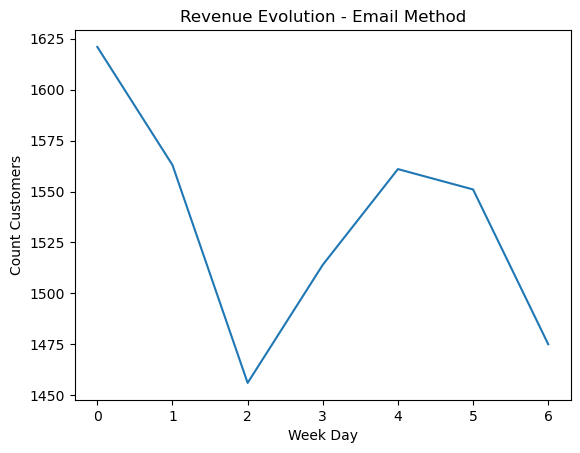

In [9]:
dates_agg= dates.groupby(["weekday"])["CUST_ID"].count().reset_index(name="Count_Customers")

x_axis = dates_agg['weekday']
y_axis = dates_agg['Count_Customers']

plt.plot(x_axis, y_axis)
plt.title('Revenue Evolution - Email Method')
plt.xlabel('Week Day')
plt.ylabel('Count Customers')
plt.show()

13. Scatter Plot (matplotlib.pyplot)

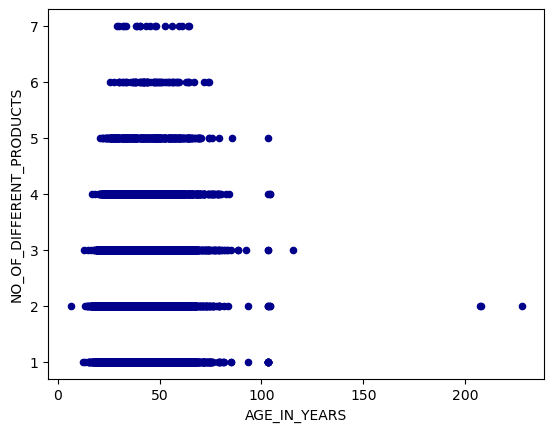

In [10]:

import matplotlib.pyplot as plot
x1 = df.plot.scatter(y='NO_OF_DIFFERENT_PRODUCTS',
                      x='AGE_IN_YEARS',
                      c='DarkBlue')



14. Heat Map (matplotlib.pyplot)

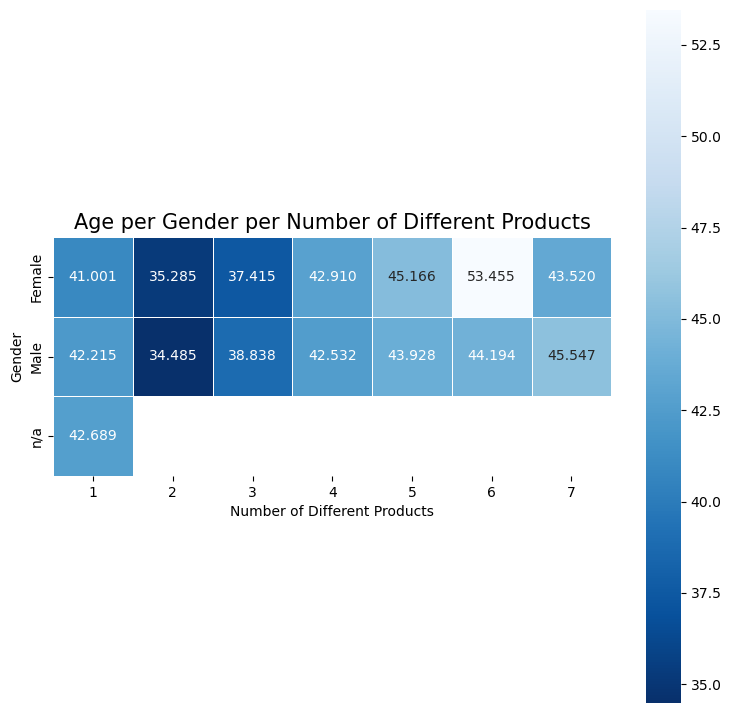

In [11]:
df_matrix = df.pivot_table(index="GENDER", columns="NO_OF_DIFFERENT_PRODUCTS", values="AGE_IN_YEARS")

plot.figure(figsize=(9,9))
sns.heatmap(df_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plot.ylabel('Gender');
plot.xlabel('Number of Different Products');
plot.title('Age per Gender per Number of Different Products', size = 15);
plot.show()  

15. Append 2 datasets

In [12]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
df_processed

,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT,GENDER_Female,GENDER_Male,GENDER_n/a,MARITAL_STATUS_Divorced,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Widowed,...,OCCUPATION_New_Salesmen,OCCUPATION_New_Skilled Worker,OCCUPATION_New_Solicitors,OCCUPATION_New_Students,OCCUPATION_New_Teachers / Professors,OCCUPATION_New_Technicians,OCCUPATION_New_Travel Agents/Airline Employees,OCCUPATION_New_University / College,OCCUPATION_New_Unskilled Worker,OCCUPATION_New_n/a
0,0.999866,0.016365,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.999851,0.017244,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.999762,0.021801,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.999620,0.027568,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.999840,0.017868,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10092,0.996574,0.082702,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10093,0.994563,0.104132,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
10094,0.995853,0.090979,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
10095,0.999310,0.037131,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


16. Check Original dataset Variables' type

In [13]:
df_2.dtypes

CUST_ID                       int32
GENDER                       object
MARITAL_STATUS               object
NATIONALITY                  object
EDUCATION                    object
EMPLOYMENT                   object
OCCUPATION                   object
AGE_IN_YEARS                float64
NO_OF_DIFFERENT_PRODUCTS      int32
LOAN_DEFAULT                 object
dtype: object

17. Convert Integer to String

In [14]:
df_2['CUST_ID'] = df_2['CUST_ID'].map(str)
df_2.dtypes

CUST_ID                      object
GENDER                       object
MARITAL_STATUS               object
NATIONALITY                  object
EDUCATION                    object
EMPLOYMENT                   object
OCCUPATION                   object
AGE_IN_YEARS                float64
NO_OF_DIFFERENT_PRODUCTS      int32
LOAN_DEFAULT                 object
dtype: object

18. Convert String to Integer

In [15]:
df_2['CUST_ID'] = pd.to_numeric(df_2.CUST_ID )
df_2.dtypes

CUST_ID                       int64
GENDER                       object
MARITAL_STATUS               object
NATIONALITY                  object
EDUCATION                    object
EMPLOYMENT                   object
OCCUPATION                   object
AGE_IN_YEARS                float64
NO_OF_DIFFERENT_PRODUCTS      int32
LOAN_DEFAULT                 object
dtype: object

19. String replace
20. Print table variable LOV

In [16]:
df['GENDER'] = df['GENDER'].replace('Male', 'MALE')
print(df['GENDER'].unique())

['Female' 'n/a' 'MALE']


21. Where clause 1 condition (loc Function)

In [17]:
newdf = df_2.loc[(df.GENDER == 'MALE')]
newdf

,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
6,70,Male,Married,Greek Cypriot,n/a,Government - Semi-Government,Skilled Worker,54.203970,2,F
8,156,Male,n/a,Other,n/a,Retired,n/a,88.292950,3,F
11,342,Male,n/a,British,n/a,Private Company / Partnership,Other Businessmen,59.123888,3,F
13,790,Male,n/a,Greek Cypriot,n/a,Retired,n/a,80.783025,3,F
14,967,Male,n/a,Greek Cypriot,n/a,Private Company / Partnership,Restaurant or Hotel Owners,62.187543,2,F
...,...,...,...,...,...,...,...,...,...,...
10090,334793,Male,Single,Greek,n/a,Private Company / Partnership,Unskilled Worker,32.462697,3,F
10092,334915,Male,Married,Greek,n/a,Private Company / Partnership,Clerical Staff,36.150582,3,F
10093,335072,Male,Single,Russians,n/a,Partial Employment,Skilled Worker,38.203970,4,F
10095,335315,Male,Married,n/a,n/a,Selfemployed,Other Professionals,26.913073,1,T


22. Where clause  multiple condition (OR)

In [18]:
newdf = newdf.loc [ ( newdf.CUST_ID > 70 )  |  (newdf.CUST_ID < 700 ) ]
newdf

,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
6,70,Male,Married,Greek Cypriot,n/a,Government - Semi-Government,Skilled Worker,54.203970,2,F
8,156,Male,n/a,Other,n/a,Retired,n/a,88.292950,3,F
11,342,Male,n/a,British,n/a,Private Company / Partnership,Other Businessmen,59.123888,3,F
13,790,Male,n/a,Greek Cypriot,n/a,Retired,n/a,80.783025,3,F
14,967,Male,n/a,Greek Cypriot,n/a,Private Company / Partnership,Restaurant or Hotel Owners,62.187543,2,F
...,...,...,...,...,...,...,...,...,...,...
10090,334793,Male,Single,Greek,n/a,Private Company / Partnership,Unskilled Worker,32.462697,3,F
10092,334915,Male,Married,Greek,n/a,Private Company / Partnership,Clerical Staff,36.150582,3,F
10093,335072,Male,Single,Russians,n/a,Partial Employment,Skilled Worker,38.203970,4,F
10095,335315,Male,Married,n/a,n/a,Selfemployed,Other Professionals,26.913073,1,T


23. Where clause  multiple condition (AND)

In [19]:
newdf = newdf.loc [ ( newdf.CUST_ID > 70 )  &  (newdf.CUST_ID < 700 ) ]
newdf

,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
8,156,Male,n/a,Other,n/a,Retired,n/a,88.292950,3,F
11,342,Male,n/a,British,n/a,Private Company / Partnership,Other Businessmen,59.123888,3,F


24. Mutiple Aggregations (aggregate functions)

In [20]:
df2= df.groupby(["GENDER"]).aggregate({'AGE_IN_YEARS': 'sum', 'NO_OF_DIFFERENT_PRODUCTS': 'count'})

df2

,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS
GENDER,,
Female,177237.744038,4620
MALE,211821.546885,5474
n/a,128.068446,3


25. Merge 2 tables

pd.merge(
    left,
    right,
    how="inner",
    on=None,
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [21]:
result = pd.merge(df_2, dates,how = 'left' ,on="CUST_ID")
result

,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT,DATE_OF_BIRTH,FIRST_CUSTOMER_OPENING_DATE,weekday
0,10,Female,n/a,n/a,n/a,Housewife,n/a,61.097878,1,F,1943-03-26,1995-07-08,4.0
1,20,Female,n/a,n/a,n/a,n/a,n/a,57.982204,1,F,1946-05-07,1995-07-08,1.0
2,30,Female,n/a,Greek Cypriot,n/a,Housewife,n/a,45.859001,1,F,1958-06-21,1995-07-08,5.0
3,40,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,NaN,1,F,NaT,1995-07-08,NaN
4,50,Female,n/a,Greek Cypriot,n/a,Private Company / Partnership,Other Professionals,55.956194,1,F,1948-05-16,1995-07-08,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10092,334915,Male,Married,Greek,n/a,Private Company / Partnership,Clerical Staff,36.150582,3,F,1968-03-06,2003-05-22,2.0
10093,335072,Male,Single,Russians,n/a,Partial Employment,Skilled Worker,38.203970,4,F,1966-02-15,2001-07-24,1.0
10094,335190,Female,Single,Greek Cypriot,n/a,Private Company / Partnership,Unskilled Worker,21.891855,2,F,1982-06-09,2003-08-11,2.0
10095,335315,Male,Married,n/a,n/a,Selfemployed,Other Professionals,26.913073,1,T,1977-06-01,2004-02-06,2.0


In [22]:
result = pd.merge(df_2, dates,how = 'inner' ,on="CUST_ID")
result

,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT,DATE_OF_BIRTH,FIRST_CUSTOMER_OPENING_DATE,weekday
0,10,Female,n/a,n/a,n/a,Housewife,n/a,61.097878,1,F,1943-03-26,1995-07-08,4.0
1,20,Female,n/a,n/a,n/a,n/a,n/a,57.982204,1,F,1946-05-07,1995-07-08,1.0
2,30,Female,n/a,Greek Cypriot,n/a,Housewife,n/a,45.859001,1,F,1958-06-21,1995-07-08,5.0
3,40,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,NaN,1,F,NaT,1995-07-08,NaN
4,50,Female,n/a,Greek Cypriot,n/a,Private Company / Partnership,Other Professionals,55.956194,1,F,1948-05-16,1995-07-08,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10092,334915,Male,Married,Greek,n/a,Private Company / Partnership,Clerical Staff,36.150582,3,F,1968-03-06,2003-05-22,2.0
10093,335072,Male,Single,Russians,n/a,Partial Employment,Skilled Worker,38.203970,4,F,1966-02-15,2001-07-24,1.0
10094,335190,Female,Single,Greek Cypriot,n/a,Private Company / Partnership,Unskilled Worker,21.891855,2,F,1982-06-09,2003-08-11,2.0
10095,335315,Male,Married,n/a,n/a,Selfemployed,Other Professionals,26.913073,1,T,1977-06-01,2004-02-06,2.0


26. Export Pandas dataset into Project Assets panel

In [23]:
from project_lib import Project
project = Project(project_id = 'be25fa40-e354-4dbf-96a3-5e9a80976251', project_access_token= '')
project.save_data(data=result.to_csv(index=False),file_name='Data_Prep.csv',overwrite=True)


{'file_name': 'Data_Prep.csv',
 'message': 'File saved to project storage.',
 'asset_id': '5816db31-ee7e-4108-a44d-cae535a307ba'}